In [68]:
!pip install feature-engine
!pip install xgboost


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [69]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
from math import ceil, floor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from feature_engine.encoding import OrdinalEncoder
from xgboost import XGBRegressor
import pickle

pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('final_dataset_unfiltered.csv')

In [3]:
df.head()

,data_price_s,data_category_s,data_subcategories_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s,data_furnished_s,data_sku_s,data_geo_point_s,page_link_s,parent_link_s,njop,neighbors,min_njop,max_njop,std_njop,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,count_mall,max_stars_mall,sum_reviews_mall,count_hospital,max_stars_hospital,sum_reviews_hospital,count_bus_st,sum_reviews_bus_st,count_train_st,sum_reviews_train_st
0,2.000000e+08,house,"[""house"",""single-family-house""]",2,2.0,52.0,40.0,NaN,HO63342840B9EB3ID,NaN,https://www.lamudi.co.id/wujudkan-dan-desain-h...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.250000e+09,house,"[""house"",""single-family-house""]",3,2.0,200.0,200.0,NaN,HO63CE42B5E3B0AID,NaN,https://www.lamudi.co.id/rumah-kedungmundu-mur...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.910000e+08,house,"[""house"",""single-family-house""]",2,2.0,55.0,60.0,NaN,HO62B162B0CB941ID,NaN,https://www.lamudi.co.id/rumah-2-lt-hot-promo-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.200000e+09,house,"[""house"",""single-family-house""]",3,1.0,80.0,150.0,NaN,HO5E2567A098B1DID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
4,2.100000e+09,house,"[""house"",""single-family-house""]",6,2.0,150.0,305.0,NaN,HO60111E9AC8A8EID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


## Cleaning Dataset

### Remove Rows with No Coordinate or Wrong Coordinate

We know that Jakarta should have latitude around -5 to -6 and longitude around 106 to 107. Therefore, we are going to use that information to prevent any bias

In [4]:
df['data_geo_point_s'] = df['data_geo_point_s'].astype('str')
df['latitude'] = df['data_geo_point_s'].apply(lambda x: eval(x)[1] if x != 'nan' else None)
df['longitude'] = df['data_geo_point_s'].apply(lambda x: eval(x)[0] if x != 'nan' else None)
df.head()

,data_price_s,data_category_s,data_subcategories_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s,data_furnished_s,data_sku_s,data_geo_point_s,page_link_s,parent_link_s,njop,neighbors,min_njop,max_njop,std_njop,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,count_mall,max_stars_mall,sum_reviews_mall,count_hospital,max_stars_hospital,sum_reviews_hospital,count_bus_st,sum_reviews_bus_st,count_train_st,sum_reviews_train_st,latitude,longitude
0,2.000000e+08,house,"[""house"",""single-family-house""]",2,2.0,52.0,40.0,NaN,HO63342840B9EB3ID,nan,https://www.lamudi.co.id/wujudkan-dan-desain-h...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.250000e+09,house,"[""house"",""single-family-house""]",3,2.0,200.0,200.0,NaN,HO63CE42B5E3B0AID,nan,https://www.lamudi.co.id/rumah-kedungmundu-mur...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.910000e+08,house,"[""house"",""single-family-house""]",2,2.0,55.0,60.0,NaN,HO62B162B0CB941ID,nan,https://www.lamudi.co.id/rumah-2-lt-hot-promo-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.200000e+09,house,"[""house"",""single-family-house""]",3,1.0,80.0,150.0,NaN,HO5E2567A098B1DID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-6.19651,106.95499
4,2.100000e+09,house,"[""house"",""single-family-house""]",6,2.0,150.0,305.0,NaN,HO60111E9AC8A8EID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-6.19651,106.95499


In [5]:
df['latitude'].astype('str').str[:3].value_counts()

latitude
-6.    64340
nan    14621
90.       94
0.0       25
6.0       13
8.0        9
-7.        5
12.        4
-5.        3
15.        3
10.        3
7.0        3
1.0        2
6.3        1
11.        1
-9.        1
13.        1
0.4        1
6.1        1
17.        1
3.5        1
21.        1
20.        1
14.        1
-8.        1
3.7        1
4.0        1
-56        1
Name: count, dtype: int64

In [6]:
df['longitude'].astype('str').str[:3].value_counts()

longitude
106    64138
nan    14621
180      276
0.0       25
107       20
15.       11
16.        7
1.0        6
20.        5
14.        3
10.        3
12.        3
25.        3
17.        3
22.        2
100        1
105        1
40.        1
50.        1
101        1
9.0        1
13.        1
89.        1
112        1
28.        1
21.        1
104        1
24.        1
108        1
Name: count, dtype: int64

In [7]:
df = df[ (df['latitude'].between(-7, -5)) & (df['longitude'].between(106, 108)) ].reset_index(drop=True)

In [8]:
df

,data_price_s,data_category_s,data_subcategories_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s,data_furnished_s,data_sku_s,data_geo_point_s,page_link_s,parent_link_s,njop,neighbors,min_njop,max_njop,std_njop,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,count_mall,max_stars_mall,sum_reviews_mall,count_hospital,max_stars_hospital,sum_reviews_hospital,count_bus_st,sum_reviews_bus_st,count_train_st,sum_reviews_train_st,latitude,longitude
0,1.200000e+09,house,"[""house"",""single-family-house""]",3,1.0,80.0,150.0,NaN,HO5E2567A098B1DID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-6.196510,106.954990
1,2.100000e+09,house,"[""house"",""single-family-house""]",6,2.0,150.0,305.0,NaN,HO60111E9AC8A8EID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-6.196510,106.954990
2,3.900000e+09,house,"[""house"",""single-family-house""]",5,4.0,176.0,435.0,NaN,HO6011157C5AD91ID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-hoek-siap-huni-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-6.196510,106.954990
3,4.500000e+09,house,"[""house"",""single-family-house""]",4,2.0,264.0,310.0,NaN,HO60234F25B1350ID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-2lt-siap-huni-l...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-6.196510,106.954990
4,2.489000e+09,house,"[""house"",""single-family-house""]",5,3.0,300.0,184.0,NaN,HO5C95074904CCEID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-2-lantai-luas-1...,https://www.lamudi.co.id/jakarta/kepulauan-ser...,5.311486e+06,182.0,2640000.0,8145000.0,2.108699e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,7293.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-6.196510,106.954990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64055,4.300000e+09,house,"[""house"",""single-family-house""]",3,2.0,245.0,126.0,NaN,HO6364C8B7A3C09ID,"[106.865237,-6.137171]",https://www.lamudi.co.id/rumah-sunter-agung-mu...,https://www.lamudi.co.id/jakarta/jakarta-utara...,1.916743e+07,153.0,4155000.0,28855000.0,3.435436e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.5,12280.0,4.0,4.6,4656.0,3.0,110.0,0.0,0.0,-6.137171,106.865237
64056,2.900000e+10,house,"[""house"",""single-family-house""]",6,4.0,1200.0,1040.0,NaN,HO63D662483CD7CID,"[106.865237,-6.137171]",https://www.lamudi.co.id/rumah-sunter-agung-in...,https://www.lamudi.co.id/jakarta/jakarta-utara...,1.916743e+07,153.0,4155000.0,28855000.0,3.435436e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.5,12280.0,4.0,4.6,4656.0,3.0,110.0,0.0,0.0,-6.137171,106.865237
64057,3.300000e+09,house,"[""house"",""single-family-house""]",3,3.0,200.0,96.0,NaN,HO643FB884DFB95ID,"[106.865237,-6.137171]",https://www.lamudi.co.id/rumah-minimalis-3-lan...,https://www.lamudi.co.id/jakarta/jakarta-utara...,1.916743e+07,153.0,4155000.0,28855000.0,3.435436e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.5,12280.0,4.0,4.6,4656.0,3.0,110.0,0.0,0.0,-6.137171,106.865237
64058,2.500000e+09,house,"[""house"",""single-family-house""]",4,3.0,110.0,93.0,NaN,HO642FE87DB55C9ID,"[106.865237,-6.137171]",https://www.lamudi.co.id/dijual-rumah-sunter-a...,https://www.lamudi.co.id/jakarta/jakarta-utara...,1.916743e+07,153.0,4155000.0,28855000.0,3.435436e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.5,12280.0,4.0,4.6,4656.0,3.0,110.0,0.0,0.0,-6.137171,106.865237


### Remove Kepulauan Seribu

We have seen that there aren't many houses being sold in _Kepulauan Seribu_, thus creating a rare label. In this particular project, we are going to remove it altogether and define our scope for houses in every _Kabupaten_ in Jakarta except _Kepulauan Seribu_

In [9]:
kabupaten_pattern = r'([-\w]+)/([-\w]+)/house/buy/$'
df['kabupaten'] = df['parent_link_s'].apply(lambda x: re.search(kabupaten_pattern, x)[1])

In [10]:
df = df[ df['kabupaten'] != 'kepulauan-seribu' ].reset_index(drop=True)

### Remove Outlier Values for Numerical Variable

In [11]:
cols = ['data_bedrooms_s', 'data_bathrooms_s', 'data_building_size_s', 'data_land_size_s']
for col in cols:
    if col in ['data_bedrooms_s', 'data_bathrooms_s']:
        min_col = 1
    if col in ['data_building_size_s', 'data_land_size_s']:
        min_col = 6
    max_col = np.percentile(df[col], 99)
    df = df[ df[col].between(min_col, max_col) ].reset_index(drop=True)
df.head()

,data_price_s,data_category_s,data_subcategories_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s,data_furnished_s,data_sku_s,data_geo_point_s,page_link_s,parent_link_s,njop,neighbors,min_njop,max_njop,std_njop,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,count_mall,max_stars_mall,sum_reviews_mall,count_hospital,max_stars_hospital,sum_reviews_hospital,count_bus_st,sum_reviews_bus_st,count_train_st,sum_reviews_train_st,latitude,longitude,kabupaten
0,1.625000e+09,house,"[""house"",""single-family-house""]",4,3.0,140.0,66.0,NaN,HO63CC78CE54E48ID,"[106.8029,-6.3454]",https://www.lamudi.co.id/rumah-classic-3-lanta...,https://www.lamudi.co.id/jakarta/jakarta-selat...,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.345400,106.802900,jakarta-selatan
1,1.650000e+09,house,"[""house"",""single-family-house""]",5,5.0,170.0,107.0,NaN,HO6343EC6B92230ID,"[106.8029,-6.3454]",https://www.lamudi.co.id/rumah-lux-modern-clas...,https://www.lamudi.co.id/jakarta/jakarta-selat...,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.345400,106.802900,jakarta-selatan
2,1.250000e+09,house,"[""house"",""single-family-house""]",2,2.0,100.0,50.0,NaN,HO640EE5B4E45A2ID,"[106.8029,-6.3454]",https://www.lamudi.co.id/rumah-mewah-classic-h...,https://www.lamudi.co.id/jakarta/jakarta-selat...,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.345400,106.802900,jakarta-selatan
3,2.550000e+09,house,"[""house"",""townhouse""]",4,4.0,200.0,93.0,NaN,HO62F4ED2CDEF8CID,"[106.8029,-6.3454]",https://www.lamudi.co.id/rumah-mewah-dijual-di...,https://www.lamudi.co.id/jakarta/jakarta-selat...,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.345400,106.802900,jakarta-selatan
4,1.800000e+09,house,"[""house"",""townhouse""]",3,3.0,145.0,86.0,NaN,HO63D23C0D7A27FID,"[106.80943550727,-6.3343581041538]",https://www.lamudi.co.id/rumah-mewah-murah-jag...,https://www.lamudi.co.id/jakarta/jakarta-selat...,4.290899e+06,85.0,2779000.0,9063000.0,1.159230e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,4.0,4.5,3931.0,0.0,0.0,0.0,0.0,-6.334358,106.809436,jakarta-selatan


In [12]:
len(df)

60914

### Single Family House Oriented Model

We remembered that there were 'villa', 'townhouse', 'subsidized-house', 'house', 'boarding-house', and 'single-family-house' in the subcategory. We will further narrow our scope to 'single-family-house' for this model

In [13]:
df['single_family_house'] = df['data_subcategories_s'].apply(lambda x: '"single-family-house"' in x)

In [14]:
df = df[ df['single_family_house'] ].reset_index(drop=True)

### Remove Duplicates by SKU

In [15]:
df = df.drop_duplicates('data_sku_s', keep='first').reset_index(drop=True)
print('Number of rows after dropping duplicate rows:', len(df))

Number of rows after dropping duplicate rows: 54320


### Create Floor Numbers

In [16]:
df['floor_by_size'] = np.vectorize(ceil)(df['data_building_size_s']/df['data_land_size_s'])
floor_pattern = '(\d+).?(lantai|lt)'
df['floor_pattern'] = df['page_link_s'].apply(lambda x: re.search(floor_pattern, x)[1] if re.search(floor_pattern, x) else 0).astype(int)

def get_floor(floor_pattern, floor_by_size):
    if floor_pattern != 0 and floor_pattern < 5:
        return floor_pattern
    else:
        return floor_by_size

df['floor'] = np.vectorize(get_floor)(df['floor_pattern'], df['floor_by_size'])
df = df.drop(['floor_pattern','floor_by_size'], axis=1)

### Create _Kecamatan_

In [17]:
kecamatan_pattern = r'/([-\w]+)/house/buy/$'
df['kecamatan'] = df['parent_link_s'].apply(lambda x: re.search(kecamatan_pattern, x)[1])

### Check Missing Values

In [18]:
df = df[ ~df['data_price_s'].isna() ].reset_index(drop=True)

We also saw that there are many houses that are outside our NJOP range since they are located outside of Jakarta. For now, let's just remove them since this is preparation for first iteration model

In [19]:
df = df[ ~df['std_njop'].isna() ].reset_index(drop=True)

We also saw furnished data is null along the way

In [20]:
df = df.drop('data_furnished_s', axis=1)

In [21]:
df.isna().sum()[df.isna().sum() > 0]

max_stars_mall        15556
max_stars_hospital     1365
dtype: int64

We'll impute 0 if there are no values in the max column

In [22]:
df[['max_stars_mall', 'max_stars_hospital']] = df[['max_stars_mall', 'max_stars_hospital']].fillna(0)

### Dropping Unused Columns

In [23]:
model_columns = ['data_price_s', 'data_bedrooms_s', 'data_bathrooms_s', 'floor', 'data_land_size_s', 'data_building_size_s', 'njop'
                 , 'neighbors', 'min_njop', 'max_njop', 'std_njop', 'flood_0', 'flood_1', 'flood_2', 'flood_3', 'flood_4'
                 , 'flood_5', 'flood_6', 'count_mall', 'max_stars_mall', 'sum_reviews_mall', 'count_hospital', 'max_stars_hospital'
                 , 'sum_reviews_hospital', 'count_bus_st', 'sum_reviews_bus_st', 'count_train_st', 'sum_reviews_train_st'
                 , 'latitude', 'longitude', 'kabupaten', 'kecamatan']
df = df[model_columns]

In [24]:
df.head()

,data_price_s,data_bedrooms_s,data_bathrooms_s,floor,data_land_size_s,data_building_size_s,njop,neighbors,min_njop,max_njop,std_njop,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,count_mall,max_stars_mall,sum_reviews_mall,count_hospital,max_stars_hospital,sum_reviews_hospital,count_bus_st,sum_reviews_bus_st,count_train_st,sum_reviews_train_st,latitude,longitude,kabupaten,kecamatan
0,1.625000e+09,4,3.0,3,66.0,140.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,jakarta-selatan,jagakarsa
1,1.650000e+09,5,5.0,2,107.0,170.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,jakarta-selatan,jagakarsa
2,1.250000e+09,2,2.0,2,50.0,100.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,jakarta-selatan,jagakarsa
3,1.700000e+09,4,4.0,2,95.0,130.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,jakarta-selatan,jagakarsa
4,2.340372e+09,4,4.0,2,110.0,140.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,jakarta-selatan,jagakarsa


### Cleaning _Kecamatan_ and _Kelurahan_

In [25]:
df_njop = pd.read_csv('NJOP2021.csv')
df_njop = df_njop.drop('Unnamed: 0', axis=1)
cols = ['provinsi', 'kota', 'kecamatan', 'kelurahan']
for col in cols:
    df_njop[col] = df_njop[col].apply(lambda x: str(x).split(' - ')[1])
df_njop.head()

,provinsi,kota,kecamatan,kelurahan,blk,nama_jalan,znt,kelas_bumi,min_njb,sd,max_njb,ave_njb,page_num
0,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN LAMA,PONDOK PINANG,1,GG FLAMBOYAN,AB,136,"5,625,000",s/d,"5,900,000","5,763,000",4
1,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN LAMA,PONDOK PINANG,1,GG FLAMBOYAN,AA,138,"5,095,000",s/d,"5,350,000","5,223,000",4
2,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN LAMA,PONDOK PINANG,1,GG H MASRIKI,AB,136,"5,625,000",s/d,"5,900,000","5,763,000",4
3,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN LAMA,PONDOK PINANG,1,GG H SAEMIN,AB,136,"5,625,000",s/d,"5,900,000","5,763,000",4
4,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN LAMA,PONDOK PINANG,1,GG H SAEMIN,AA,138,"5,095,000",s/d,"5,350,000","5,223,000",4


In [26]:
df_njop['kota'].unique()

array(['JAKARTA SELATAN', 'JAKARTA TIMUR', 'JAKARTA PUSAT',
       'JAKARTA BARAT', 'JAKARTA UTARA', 'KEPULAUAN SERIBU'], dtype=object)

In [27]:
df['kabupaten'] = df['kabupaten'].apply(lambda x: x.upper().replace('-', ' '))

In [28]:
remove_spaces = ['P U L O', 'C I K O K O', 'P A N C O R A N', 'R A G U N A N', 'S E L O N G', 'S E N A Y A N', 'K A R E T', 'G U N T U R', 'KALI BATA', 'B A N G K A', 'U L U J A M I', 'C I P U L I R', 'PAL MERIAM', 'KALI ANYAR', 'RAWA JATI', 'SETIA BUDI']
df_njop['kelurahan'] = df_njop['kelurahan'].apply(lambda x: x.replace(' ', '') if x in remove_spaces else x)
df_njop['kelurahan'] = df_njop['kelurahan'].str.replace('KEBAYORAN LAMA UTR', 'KEBAYORAN LAMA UTARA').str.replace('KEBAYORAN LAMA SLT', 'KEBAYORAN LAMA SELATAN').str.replace('BALIMESTER', 'BALI MESTER')

In [29]:
sorted(set(df['kecamatan'].unique()))

['ancol',
 'bendungan-hilir',
 'cakung',
 'cempaka-putih-1',
 'cengkareng',
 'cibubur',
 'cilandak',
 'cilincing',
 'cipayung-1',
 'ciracas',
 'duren-sawit',
 'gambir',
 'grogol-petamburan',
 'jagakarsa',
 'jatinegara-1',
 'jelambar',
 'johar-baru',
 'kalideres',
 'kebayoran-baru',
 'kebayoran-lama',
 'kebon-jeruk',
 'kelapa-gading',
 'kemang',
 'kemayoran-2',
 'kembangan',
 'kuningan-2',
 'menteng',
 'pademangan',
 'palmerah',
 'pantai-indah-kapuk',
 'pasar-minggu',
 'pasar-rebo',
 'penjaringan',
 'pluit',
 'pondok-indah',
 'pondok-kelapa-1',
 'pulo-gadung',
 'puri-indah',
 'rawamangun',
 'sawah-besar-1',
 'senen',
 'setia-budi',
 'sunter',
 'sunter-agung',
 'tanah-abang',
 'tanah-sereal',
 'tanjung-duren-utara',
 'tanjung-priok',
 'tebet',
 'thamrin']

In [30]:
sorted(set(df_njop['kecamatan'].unique()))

['C I L A N D A K',
 'CAKUNG',
 'CEMPAKA PUTIH',
 'CENGKARENG',
 'CILINCING',
 'CIPAYUNG',
 'CIRACAS',
 'DUREN SAWIT',
 'GAMBIR',
 'GROGOL PETAMBURAN',
 'J A G A K A R S A',
 'JATINEGARA',
 'JOHAR BARU',
 'KALIDERES',
 'KEBAYORAN BARU',
 'KEBAYORAN LAMA',
 'KEBON JERUK',
 'KELAPA GADING',
 'KEMAYORAN',
 'KEMBANGAN',
 'KEPULAUAN SERIBU SELATAN',
 'KEPULAUAN SERIBU UTARA',
 'KOJA',
 'KRAMAT JATI',
 'MAKASAR',
 'MAMPANG PRAPATAN',
 'MATRAMAN',
 'MENTENG',
 'P A N C O R A N',
 'PADEMANGAN',
 'PALMERAH',
 'PASAR MINGGU',
 'PASAR REBO',
 'PENJARINGAN',
 'PESANGGRAHAN',
 'PULO GADUNG',
 'SAWAH BESAR',
 'SENEN',
 'SETIA BUDI',
 'T E B E T',
 'TAMAN SARI',
 'TAMBORA',
 'TANAH ABANG',
 'TANJUNG PRIOK']

In [31]:
dict_kecamatan = {"ancol": "pademangan", "bendungan-hilir": "tanah-abang", "cempaka-putih-1": "cempaka-putih"
                  , "cibubur": "ciracas", "cipayung-1": "cipayung", "jatinegara-1": "jatinegara", "jelambar": "grogol-petamburan"
                  , "jatinegara-1": "jatinegara", "kemayoran-2": "kemayoran", "kuningan-2": "setiabudi", "setia-budi": "setiabudi"
                  , "pantai-indah-kapuk": "penjaringan", "pluit": "penjaringan", "pondok-indah": "kebayoran-lama"
                  , "pondok-kelapa-1": "duren-sawit", "puri-indah": "kembangan", "rawamangun": "pulo-gadung"
                  , "sawah-besar-1": "sawah-besar", "tanah-sereal": "tambora", "tanjung-duren-utara": "grogol-petamburan"
                  , "thamrin": "menteng"}

In [32]:
remove_spaces = ['C I L A N D A K', 'J A G A K A R S A', 'P A N C O R A N', 'T E B E T', 'SETIA BUDI']
df_njop['kecamatan'] = df_njop['kecamatan'].apply(lambda x: x.replace(' ', '') if x in remove_spaces else x)

In [33]:
df['kecamatan'] = df['kecamatan'].apply(lambda x: dict_kecamatan[x] if x in dict_kecamatan else x).apply(lambda x: str(x).upper().replace('-', ' '))

In [34]:
df = df.rename(columns={'kabupaten': 'kota'})

In [35]:
df.head()

,data_price_s,data_bedrooms_s,data_bathrooms_s,floor,data_land_size_s,data_building_size_s,njop,neighbors,min_njop,max_njop,std_njop,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,count_mall,max_stars_mall,sum_reviews_mall,count_hospital,max_stars_hospital,sum_reviews_hospital,count_bus_st,sum_reviews_bus_st,count_train_st,sum_reviews_train_st,latitude,longitude,kota,kecamatan
0,1.625000e+09,4,3.0,3,66.0,140.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,JAKARTA SELATAN,JAGAKARSA
1,1.650000e+09,5,5.0,2,107.0,170.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,JAKARTA SELATAN,JAGAKARSA
2,1.250000e+09,2,2.0,2,50.0,100.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,JAKARTA SELATAN,JAGAKARSA
3,1.700000e+09,4,4.0,2,95.0,130.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,JAKARTA SELATAN,JAGAKARSA
4,2.340372e+09,4,4.0,2,110.0,140.0,4.067258e+06,122.0,2508000.0,7701000.0,1.430775e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.2,1033.0,0.0,0.0,0.0,0.0,-6.3454,106.8029,JAKARTA SELATAN,JAGAKARSA


We now have our cleaner dataset. Hooray!

### Further EDA with Complete Dataset

Hypothesis: NJOP Price should correspond to Price/(Land Area + Building Area). Therefore, let's define a normalized parameter as the Price divided by (Land Area + Building Area) divided by NJOP Price

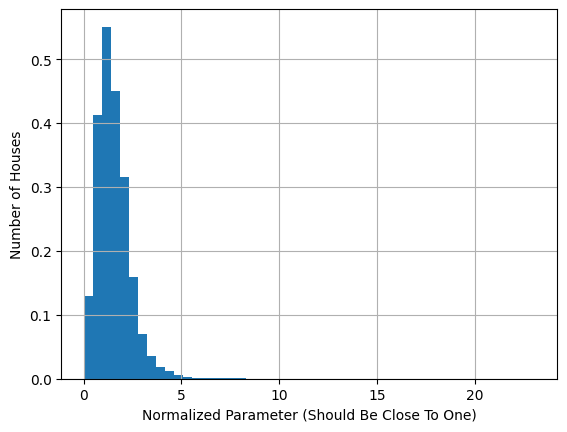

In [36]:
((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']).hist(bins=50, density=True)
plt.ylabel('Number of Houses')
plt.xlabel('Normalized Parameter (Should Be Close To One)')
plt.show()

In [37]:
((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']).describe()

count    53337.000000
mean         1.533308
std          0.890374
min          0.015489
25%          0.937140
50%          1.390404
75%          1.961353
max         23.067076
dtype: float64

In [38]:
np.percentile(((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']), 99)

4.3747089359640725

In [39]:
df[
        ((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop'])
        >= np.percentile(((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']), 99)
]['kecamatan'].value_counts()

kecamatan
KEBAYORAN BARU       248
KEBAYORAN LAMA       105
CAKUNG                35
MENTENG               15
TEBET                 15
PULO GADUNG           12
TANJUNG PRIOK         11
CIPAYUNG              11
CIRACAS               11
KALIDERES             10
JAGAKARSA              8
KEMANG                 6
PASAR REBO             6
CENGKARENG             5
DUREN SAWIT            5
CILINCING              5
GROGOL PETAMBURAN      4
PENJARINGAN            4
CILANDAK               4
SETIABUDI              3
TANAH ABANG            3
KEMBANGAN              2
JOHAR BARU             2
PALMERAH               1
PASAR MINGGU           1
KELAPA GADING          1
SUNTER                 1
Name: count, dtype: int64

We can see that many of the upper outliers of the normalized is clustered in _Kecamatan_ Kebayoran Baru and Kebayoran Lama. This is good information since we can capture the information with other variables

Let's take a look at the lower outliers

In [40]:
df[
        ((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop'])
        <= np.percentile(((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']), 1)
]['kecamatan'].value_counts()

kecamatan
SUNTER               185
TANAH ABANG          131
KEBAYORAN LAMA        35
SETIABUDI             33
MENTENG               25
PALMERAH              20
KEMBANGAN             15
PASAR MINGGU          13
GAMBIR                13
SAWAH BESAR           10
PENJARINGAN            7
GROGOL PETAMBURAN      6
SENEN                  5
CEMPAKA PUTIH          5
PADEMANGAN             5
KELAPA GADING          5
KEMAYORAN              3
TAMBORA                3
CILANDAK               3
KEMANG                 3
TANJUNG PRIOK          2
KEBAYORAN BARU         2
PULO GADUNG            1
KEBON JERUK            1
CENGKARENG             1
TEBET                  1
SUNTER AGUNG           1
Name: count, dtype: int64

In [41]:
np.percentile(((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']), 1)

0.24435897513805885

In [42]:
df[
        ((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop'])
        <= np.percentile(((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']), 1)
].sort_values('data_price_s', ascending=True)

,data_price_s,data_bedrooms_s,data_bathrooms_s,floor,data_land_size_s,data_building_size_s,njop,neighbors,min_njop,max_njop,std_njop,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,count_mall,max_stars_mall,sum_reviews_mall,count_hospital,max_stars_hospital,sum_reviews_hospital,count_bus_st,sum_reviews_bus_st,count_train_st,sum_reviews_train_st,latitude,longitude,kota,kecamatan
23939,1.200000e+08,2,1.0,1,60.0,36.0,1.580581e+07,268.0,4.723000e+06,44163000.0,8.329678e+06,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,4.5,45439.0,6.0,4.4,3336.0,9.0,106091.0,1.0,3181.0,-6.176647,106.807896,JAKARTA BARAT,PALMERAH
41491,1.300000e+08,2,1.0,1,60.0,36.0,1.615729e+07,119.0,6.195000e+06,69123000.0,9.277376e+06,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,4.6,35717.0,5.0,5.0,3510.0,8.0,616.0,4.0,2126.0,-6.206173,106.807407,JAKARTA PUSAT,TANAH ABANG
41366,1.300000e+08,2,1.0,1,60.0,36.0,1.427014e+07,116.0,5.763000e+06,69123000.0,8.057367e+06,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,4.6,35717.0,6.0,5.0,3835.0,7.0,583.0,4.0,2126.0,-6.204661,106.805912,JAKARTA PUSAT,TANAH ABANG
41522,1.390000e+08,2,1.0,1,60.0,22.0,1.429455e+07,123.0,5.763000e+06,46373000.0,7.025069e+06,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,4.6,35717.0,6.0,5.0,3835.0,7.0,583.0,4.0,2126.0,-6.204600,106.804900,JAKARTA PUSAT,TANAH ABANG
15134,1.500000e+08,2,1.0,1,34.0,30.0,9.752809e+06,33.0,3.843000e+06,29223000.0,7.783261e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.6,2504.0,2.0,3.9,322.0,3.0,248.0,0.0,0.0,-6.295478,106.817228,JAKARTA SELATAN,PASAR MINGGU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50015,8.000000e+09,5,6.0,2,396.0,612.0,3.350653e+07,23.0,1.186833e+07,51843000.0,1.471604e+07,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,4.5,101179.0,2.0,4.5,3552.0,3.0,106.0,0.0,0.0,-6.141205,106.887050,JAKARTA UTARA,SUNTER
49379,8.500000e+09,5,5.0,4,250.0,1000.0,3.350653e+07,23.0,1.186833e+07,51843000.0,1.471604e+07,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,4.5,101179.0,2.0,4.5,3552.0,3.0,106.0,0.0,0.0,-6.141205,106.887050,JAKARTA UTARA,SUNTER
49380,9.250000e+09,9,9.0,2,459.0,820.0,3.350653e+07,23.0,1.186833e+07,51843000.0,1.471604e+07,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,4.5,101179.0,2.0,4.5,3552.0,3.0,106.0,0.0,0.0,-6.141205,106.887050,JAKARTA UTARA,SUNTER
49135,9.250000e+09,4,4.0,1,800.0,480.0,3.350653e+07,23.0,1.186833e+07,51843000.0,1.471604e+07,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,4.5,101179.0,2.0,4.5,3552.0,3.0,106.0,0.0,0.0,-6.141205,106.887050,JAKARTA UTARA,SUNTER


In [43]:
df = df[
    ((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop'])\
    .between(np.percentile(((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']), 1)
    , np.percentile(((df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/df['njop']), 99))
].reset_index(drop=True)

### Split Dataset to Train and Test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('data_price_s', axis=1)
    , df['data_price_s']
    , test_size=0.3
    , random_state=42
)

### Feature Engineering

In [45]:
categorical_encoder = OrdinalEncoder(encoding_method='ordered', variables=['kota', 'kecamatan'])
categorical_encoder.fit(X_train, y_train)
categorical_encoder.encoder_dict_

{'kota': {'JAKARTA TIMUR': 0,
  'JAKARTA BARAT': 1,
  'JAKARTA UTARA': 2,
  'JAKARTA SELATAN': 3,
  'JAKARTA PUSAT': 4},
 'kecamatan': {'PASAR REBO': 0,
  'CIPAYUNG': 1,
  'CIRACAS': 2,
  'CILINCING': 3,
  'CAKUNG': 4,
  'TAMBORA': 5,
  'JAGAKARSA': 6,
  'CENGKARENG': 7,
  'KALIDERES': 8,
  'JATINEGARA': 9,
  'GROGOL PETAMBURAN': 10,
  'JOHAR BARU': 11,
  'DUREN SAWIT': 12,
  'KEMAYORAN': 13,
  'SENEN': 14,
  'SUNTER AGUNG': 15,
  'PULO GADUNG': 16,
  'TANJUNG PRIOK': 17,
  'KEBON JERUK': 18,
  'KELAPA GADING': 19,
  'PASAR MINGGU': 20,
  'PALMERAH': 21,
  'GAMBIR': 22,
  'KEMBANGAN': 23,
  'CEMPAKA PUTIH': 24,
  'SUNTER': 25,
  'SAWAH BESAR': 26,
  'PADEMANGAN': 27,
  'TEBET': 28,
  'PENJARINGAN': 29,
  'CILANDAK': 30,
  'TANAH ABANG': 31,
  'KEMANG': 32,
  'KEBAYORAN LAMA': 33,
  'KEBAYORAN BARU': 34,
  'SETIABUDI': 35,
  'MENTENG': 36}}

### Create Benchmark with XGBoost and Simple Pipeline

In [46]:
pipe = Pipeline([
    ('categorical_encoder'
     , OrdinalEncoder(encoding_method='ordered'
                      , variables=['kota', 'kecamatan']))
    , ('xgbr', XGBRegressor(random_state=42))
])

In [47]:
param_grid = {
    'xgbr__learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
}

In [48]:
grid_search = GridSearchCV(pipe, param_grid
                           , cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [49]:
grid_search.fit(X_train, y_train)

print("Best Neg Mean Absolute Percentage Error", grid_search.score(X_train, y_train))

Best Neg Mean Absolute Percentage Error -0.2530521211758063


In [50]:
print("Best Neg Mean Absolute Percentage Error for test", grid_search.score(X_test, y_test))

Best Neg Mean Absolute Percentage Error for test -0.2495412537127813


In [51]:
grid_search.cv_results_['mean_test_score']

array([-0.34875716, -0.258614  , -0.27317239, -0.269086  , -0.26407731,
       -0.26340784])

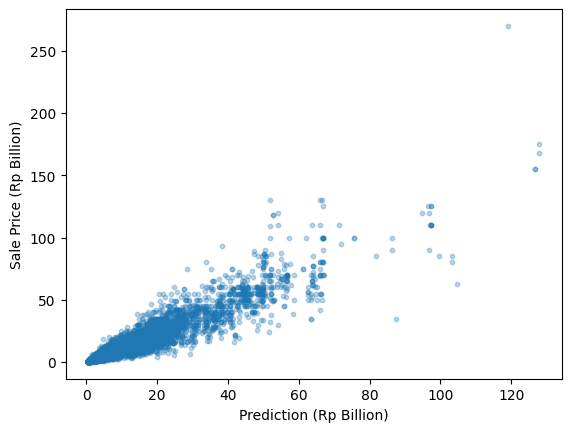

In [52]:
plt.scatter(grid_search.predict(X_test)/1000000000, y_test/1000000000, s=10, alpha=0.3)
plt.xlabel('Prediction (Rp Billion)')
plt.ylabel('Sale Price (Rp Billion)')
plt.show()

In [53]:
grid_search.best_params_

{'xgbr__learning_rate': 0.02}

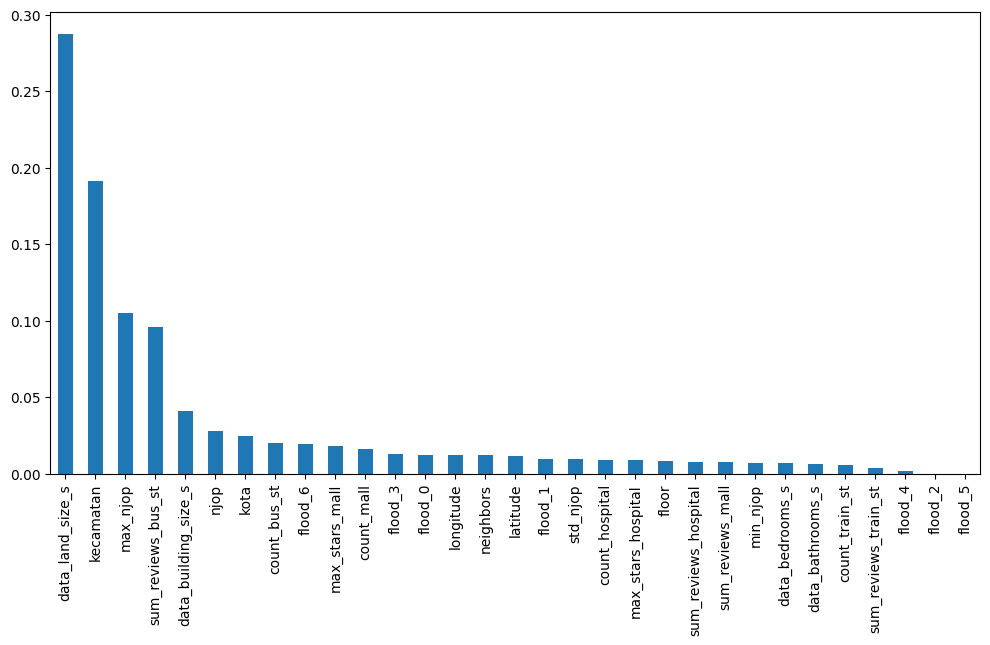

In [54]:
importance = pd.Series(grid_search.best_estimator_['xgbr'].feature_importances_)
importance.index = df.drop('data_price_s', axis=1).columns
importance = importance.sort_values(ascending=False)
importance.plot.bar(figsize=(12,6))
plt.show()

### Create Another Model that Predicts Price-per-Meter-Squared

We have seen that `data_land_size_s` plays a critical role in the previous model, which makes sense. House price should generally be a multiplication of its area. However, since I graduated from Engineering Physics and we learned thermodynamics, let's try to define an [intensive property](https://en.wikipedia.org/wiki/Intensive_and_extensive_properties), `House Price per Meter-Squared` and create a model to predict that property

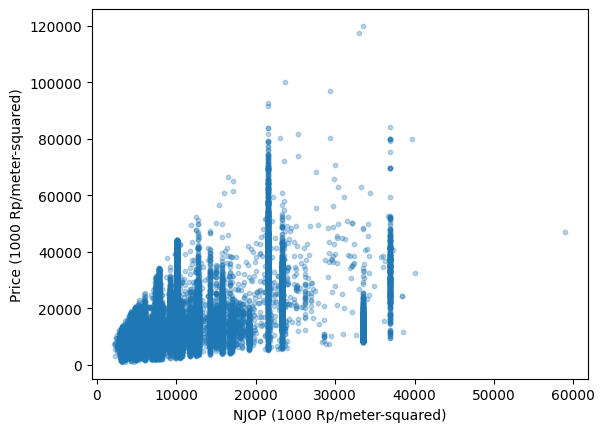

In [55]:
plt.scatter(df['njop']/1000, (df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s']))/1000, s=10, alpha=0.3)
plt.xlabel('NJOP (1000 Rp/meter-squared)')
plt.ylabel('Price (1000 Rp/meter-squared)')
plt.show()

The graph wasn't very convincing, but let's just try

In [47]:
df['price_per_size'] = df['data_price_s']/(df['data_land_size_s']+df['data_building_size_s'])
df = df.drop('data_price_s', axis=1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('price_per_size', axis=1)
    , df['price_per_size']
    , test_size=0.3
    , random_state=42
)

In [50]:
pipe = Pipeline([
    ('categorical_encoder'
     , OrdinalEncoder(encoding_method='ordered'
                      , variables=['kota', 'kecamatan']))
    , ('xgbr', XGBRegressor(random_state=42))
])

In [51]:
param_grid = {
    'xgbr__learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
}

In [52]:
grid_search = GridSearchCV(pipe, param_grid
                           , cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [53]:
grid_search.fit(X_train, y_train)

print("Negative Mean Absolute Error Train:", grid_search.score(X_train, y_train))
print("Negative Mean Absolute Error Test:", grid_search.score(X_test, y_test))

Negative Mean Absolute Error Train: -0.22494575798433736
Negative Mean Absolute Error Test: -0.238922817015397


In [54]:
grid_search.cv_results_['mean_test_score']

array([-0.35419792, -0.25188938, -0.26140643, -0.25601541, -0.25090427,
       -0.24713881])

In [55]:
grid_search.best_params_

{'xgbr__learning_rate': 0.2}

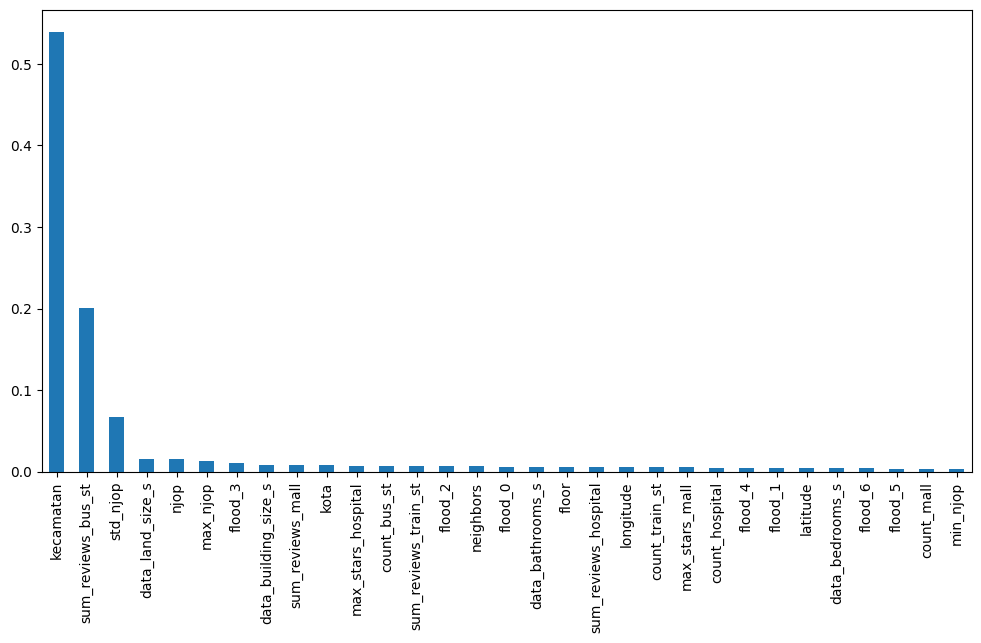

In [56]:
importance = pd.Series(grid_search.best_estimator_['xgbr'].feature_importances_)
importance.index = df.drop('price_per_size', axis=1).columns
importance = importance.sort_values(ascending=False)
importance.plot.bar(figsize=(12,6))
plt.show()

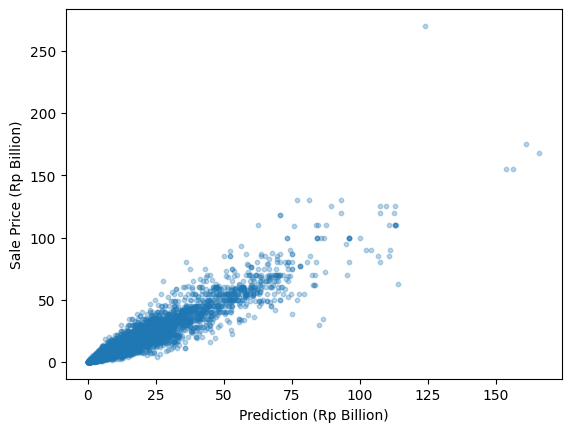

In [57]:
plt.scatter(grid_search.predict(X_test)*(X_test['data_land_size_s']+X_test['data_building_size_s'])/1000000000
            , y_test*(X_test['data_land_size_s']+X_test['data_building_size_s'])/1000000000
            , s=10, alpha=0.3)
plt.xlabel('Prediction (Rp Billion)')
plt.ylabel('Sale Price (Rp Billion)')
plt.show()

We'll continue with the second model to predict `price_per_size`

In [58]:
param_grid = {
    'xgbr__learning_rate': [0.2]
    , 'xgbr__n_estimators': [50, 100, 150, 200]
    , 'xgbr__max_depth': [5, 6, 7, 8, 9]
    , 'xgbr__min_child_weight': [1, 1.5, 2]
}

In [71]:
grid_search_tune = GridSearchCV(pipe, param_grid
                           , cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [72]:
grid_search_tune.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical_encoder',
                                        OrdinalEncoder(variables=['kota',
                                                                  'kecamatan'])),
                                       ('xgbr',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbr__learning_rate': [0.2],
                         'xgbr__max_depth': [5, 6, 7, 8, 9],
                         'xgbr__min_child_weight': [1, 1.5, 2],
                         'xgbr__n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_absolute_percentage_error')

In [73]:
print("Negative Mean Absolute Error:", grid_search_tune.score(X_train, y_train))

Negative Mean Absolute Error: -0.13305901729699718


In [74]:
print("Negative Mean Absolute Error:", grid_search_tune.score(X_test, y_test))

Negative Mean Absolute Error: -0.20179787136790328


We can see that this model overfits to our training dataset

In [75]:
grid_search_tune.best_params_

{'xgbr__learning_rate': 0.2,
 'xgbr__max_depth': 9,
 'xgbr__min_child_weight': 1,
 'xgbr__n_estimators': 200}

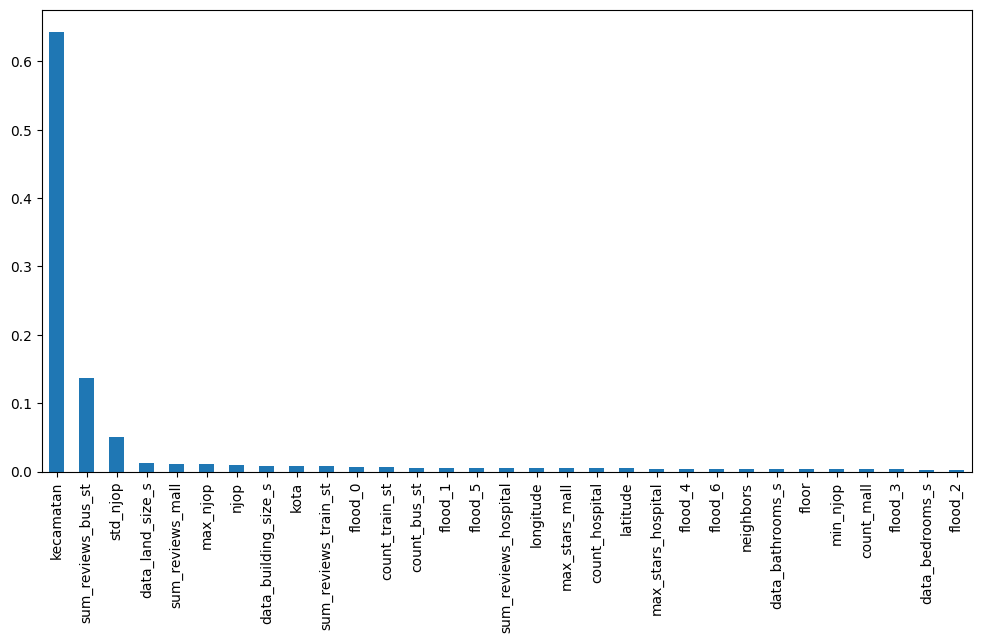

In [77]:
importance = pd.Series(grid_search_tune.best_estimator_['xgbr'].feature_importances_)
importance.index = df.drop('price_per_size', axis=1).columns
importance = importance.sort_values(ascending=False)
importance.plot.bar(figsize=(12,6))
plt.show()

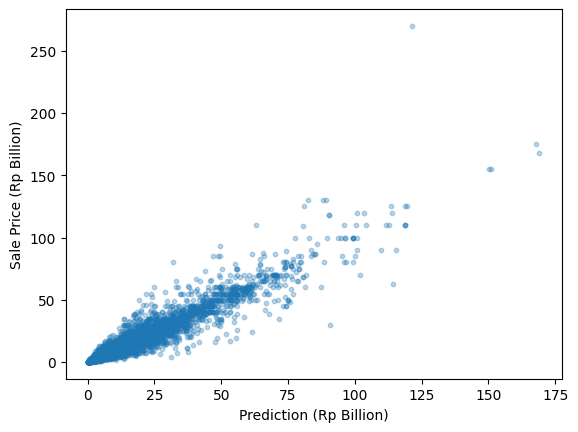

In [78]:
plt.scatter(grid_search_tune.predict(X_test)*(X_test['data_land_size_s']+X_test['data_building_size_s'])/1000000000
            , y_test*(X_test['data_land_size_s']+X_test['data_building_size_s'])/1000000000
            , s=10, alpha=0.3)
plt.xlabel('Prediction (Rp Billion)')
plt.ylabel('Sale Price (Rp Billion)')
plt.show()

We'll try to tune another parameter to prevent overfit

In [59]:
param_grid = {
    'xgbr__learning_rate': [0.2]
    , 'xgbr__n_estimators': [120]
    , 'xgbr__max_depth': [6]
    , 'xgbr__min_child_weight': [1]
    , 'xgbr__gamma': [1]
}

In [60]:
grid_search_tune = GridSearchCV(pipe, param_grid
                           , cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_search_tune.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical_encoder',
                                        OrdinalEncoder(variables=['kota',
                                                                  'kecamatan'])),
                                       ('xgbr',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbr__gamma': [1], 'xgbr__learning_rate': [0.2],
                         'xgbr__max_depth': [6], 'xgbr__min_child_weight': [1],
                         'xgbr__n_estimators': [120]},
             scoring='neg_mean_absolute_percentage_error')

In [61]:
print("Negative Mean Absolute Error Train:", grid_search_tune.score(X_train, y_train))
print("Negative Mean Absolute Error Test:", grid_search_tune.score(X_test, y_test))

Negative Mean Absolute Error Train: -0.21927954814666875
Negative Mean Absolute Error Test: -0.23572056194165467


In [62]:
param_grid = {
    'xgbr__learning_rate': [0.2]
    , 'xgbr__n_estimators': [120]
    , 'xgbr__max_depth': [6]
    , 'xgbr__min_child_weight': [1]
    , 'xgbr__gamma': [0.5]
    , 'xgbr__reg_alpha': [0.01]
    , 'xgbr__reg_lambda': [5]
}

In [63]:
grid_search_tune = GridSearchCV(pipe, param_grid
                           , cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_search_tune.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical_encoder',
                                        OrdinalEncoder(variables=['kota',
                                                                  'kecamatan'])),
                                       ('xgbr',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbr__gamma': [0.5], 'xgbr__learning_rate': [0.2],
                         'xgbr__max_depth': [6], 'xgbr__min_child_weight': [1],
                         'xgbr__n_estimators': [120], 'xgbr__reg_alpha': [0.01],
                         'xgbr__reg_lambda': [5]},
             scoring='neg_mean_absolute_percentage_error')

In [64]:
print("Negative Mean Absolute Error Train:", grid_search_tune.score(X_train, y_train))
print("Negative Mean Absolute Error Test:", grid_search_tune.score(X_test, y_test))

Negative Mean Absolute Error Train: -0.22285646275637008
Negative Mean Absolute Error Test: -0.23603570643641283


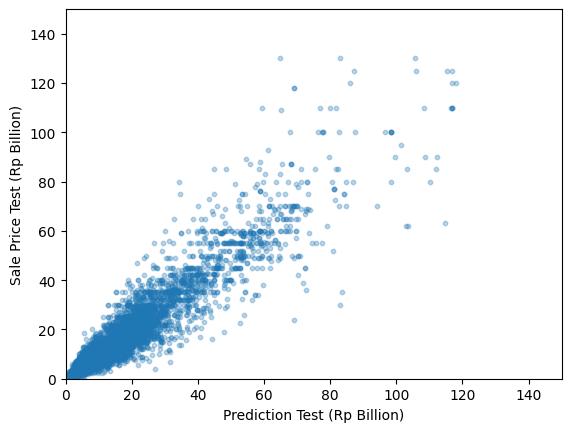

In [65]:
plt.scatter(grid_search_tune.predict(X_test)*(X_test['data_land_size_s']+X_test['data_building_size_s'])/1000000000
            , y_test*(X_test['data_land_size_s']+X_test['data_building_size_s'])/1000000000
            , s=10, alpha=0.3)
plt.xlabel('Prediction Test (Rp Billion)')
plt.ylabel('Sale Price Test (Rp Billion)')
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.show()

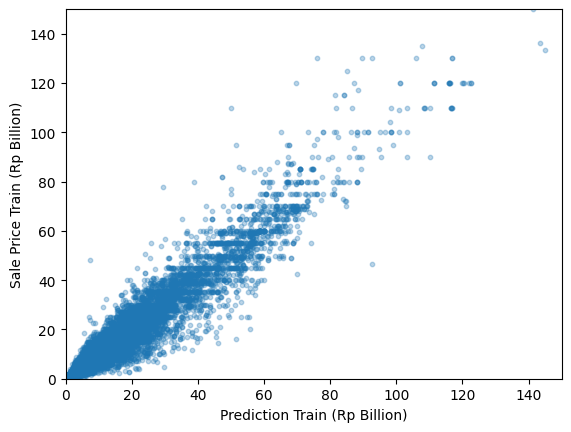

In [66]:
plt.scatter(grid_search_tune.predict(X_train)*(X_train['data_land_size_s']+X_train['data_building_size_s'])/1000000000
            , y_train*(X_train['data_land_size_s']+X_train['data_building_size_s'])/1000000000
            , s=10, alpha=0.3)
plt.xlabel('Prediction Train (Rp Billion)')
plt.ylabel('Sale Price Train (Rp Billion)')
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.show()

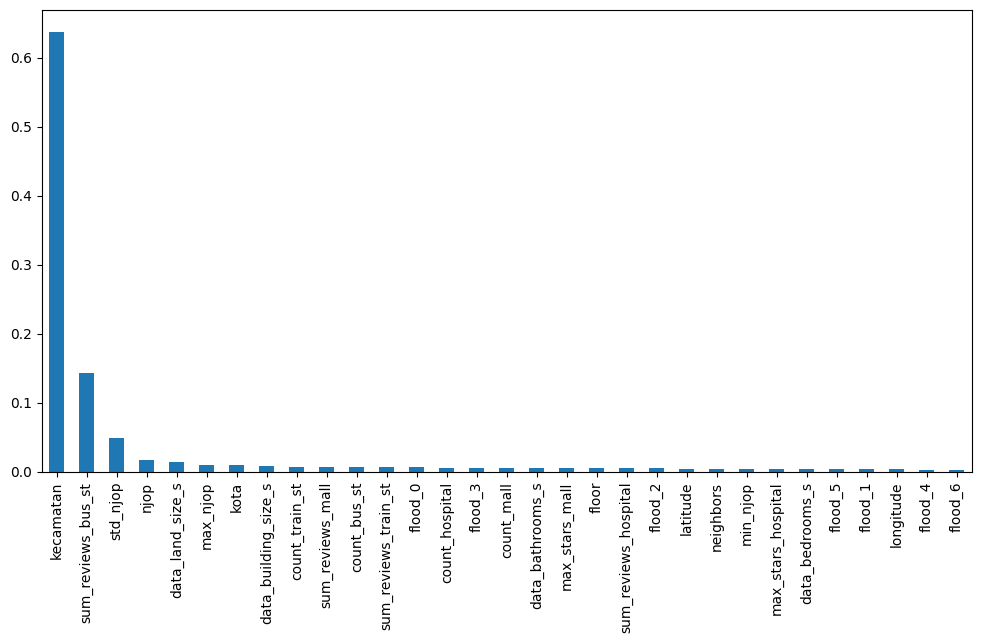

In [67]:
importance = pd.Series(grid_search_tune.best_estimator_['xgbr'].feature_importances_)
importance.index = df.drop('price_per_size', axis=1).columns
importance = importance.sort_values(ascending=False)
importance.plot.bar(figsize=(12,6))
plt.show()

Let's assume that we are satisfied with the model and we want to train the model with all data.

Our satisfaction to the model is justified since we don't have any information about the looks/quality of the house which should be a strong predictor by itself.

In [70]:
X = df.drop('price_per_size', axis=1)
y = df['price_per_size']

In [71]:
grid_search_tune.fit(X, y)

/home/yusuf/house_price_env/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) kecamatan.
  warnings.warn(
/home/yusuf/house_price_env/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) kota, kecamatan.
  warnings.warn(
/home/yusuf/house_price_env/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) kecamatan.
  warnings.warn(
/home/yusuf/house_price_env/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) kecamatan.
  warnings.warn(
/home/yusuf/house_price_env/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical_encoder',
                                        OrdinalEncoder(variables=['kota',
                                                                  'kecamatan'])),
                                       ('xgbr',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbr__gamma': [0.5], 'xgbr__learning_rate': [0.2],
                         'xgbr__max_depth': [6], 'xgbr__min_child_weight': [1],
                         'xgbr__n_estimators': [120], 'xgbr__reg_alpha': [0.01],
                         'xgbr__reg_lambda': [5]},
             scoring='neg_mean_absolute_percentage_error')

In [82]:
X['kecamatan'].unique()

array(['JAGAKARSA', 'KEBAYORAN BARU', 'CILANDAK', 'SETIABUDI', 'KEMANG',
       'TEBET', 'KEBAYORAN LAMA', 'PASAR MINGGU', 'CENGKARENG',
       'GROGOL PETAMBURAN', 'KALIDERES', 'KEMBANGAN', 'KEBON JERUK',
       'TAMBORA', 'PALMERAH', 'CAKUNG', 'CIRACAS', 'DUREN SAWIT',
       'PULO GADUNG', 'CIPAYUNG', 'JATINEGARA', 'PASAR REBO',
       'CEMPAKA PUTIH', 'MENTENG', 'TANAH ABANG', 'KEMAYORAN', 'SENEN',
       'GAMBIR', 'JOHAR BARU', 'SAWAH BESAR', 'KELAPA GADING',
       'PENJARINGAN', 'SUNTER', 'TANJUNG PRIOK', 'PADEMANGAN',
       'CILINCING', 'SUNTER AGUNG'], dtype=object)

In [83]:
with open('model.pkl', 'wb') as f:
    pickle.dump(grid_search_tune, f)
f.close()

In [86]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
predictions = model.predict(X)